# **Quick analysis on *Roughing the Passer* penalty**

"Because the act of passing often puts the quarterback (or any other player attempting a pass) in a position where he is particularly vulnerable to injury, special rules against roughing the passer apply. The Referee has principal responsibility for enforcing these rules. Any physical acts against a player who is in a passing posture (i.e. before, during, or after a pass) which, in the Referee’s judgment, are unwarranted by the circumstances of the play will be called as fouls." [nfl.com](https://operations.nfl.com/the-rules/nfl-video-rulebook/roughing-the-passer/#:~:text=Penalty%3A%20For%20Roughing%20the%20Passer,first%20down%3B%20disqualification%20if%20flagrant.&text=When%20in%20doubt%20about%20a,always%20call%20roughing%20the%20passer.)

This notebook is a quick study and visualization on the frequency of roughing the passer penalties and whether they seem to affect teams unevenly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px

from nflmodels.dataloading import load_data_postgresql

### Loading data

In [2]:
from dotenv import load_dotenv
load_dotenv()

df = load_data_postgresql(min_season=2000, max_season=2022, verbose=False, cols=['qb_hit', 'sack', 'penalty_player_name', 'penalty_type', 'passer_player_name', 'qb_hit_1_player_name', 'qb_hit_2_player_name', 
                          'sack_player_name', 'half_sack_1_player_name', 'half_sack_2_player_name',], from_env=True)

c:\users\eemeli\documents\github\nflmodels\nflmodels\dataloading.py:100: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql=query, con=conn)


In [3]:
df['rtp'] = np.where(df['penalty_type'] == "Roughing the Passer", 1, 0)
df['hit'] = np.where((df['qb_hit'] == 1) | (df['sack'] == 1), 1, 0)

df['rtp'].value_counts()

0    1100083
1       2312
Name: rtp, dtype: int64

In [6]:
df.groupby(by='season')[['qb_hit', 'sack', 'rtp']].agg('sum')

,qb_hit,sack,rtp
season,,,
2000,1081.0,1272.0,78
2001,1045.0,1241.0,79
2002,999.0,1214.0,104
2003,898.0,1134.0,108
2004,989.0,1249.0,132
2005,71.0,1235.0,116
2006,2165.0,1202.0,96
2007,2092.0,1136.0,62
2008,2074.0,1075.0,62


In [7]:
seasons = [2022]

t = df.query('season in @seasons').groupby(by='posteam')[['rtp', 'hit']].agg('sum')
t['ratio'] = t['rtp'] / t['hit']
t = t.sort_values(by='ratio', ascending=True).reset_index()

t2 = df.query('season in @seasons').groupby(by='defteam')[['rtp', 'hit']].agg('sum')
t2['ratio'] = t2['rtp'] / t2['hit']
t2 = t2.sort_values(by='ratio', ascending=False).reset_index()

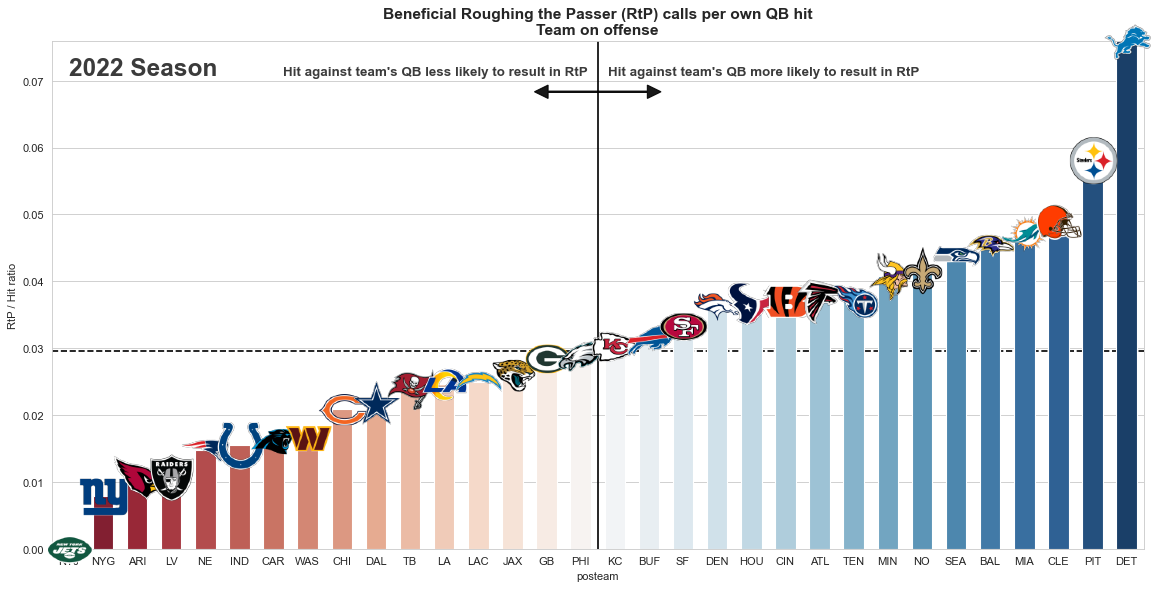

In [8]:
import requests
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

data = t

fig, ax = plt.subplots(figsize=(16,8), dpi=80)

sns.barplot(ax=ax, data=data, x='posteam', y='ratio', palette='RdBu', width=0.6)
ax.set_title('Beneficial Roughing the Passer (RtP) calls per own QB hit\nTeam on offense', fontsize=14, fontweight=600)
ax.set_ylabel('RtP / Hit ratio')
ax.set_yticks(np.arange(0,1,0.01))

# logos
for index, row in data.iterrows():
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{row["posteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.7)
    ab = AnnotationBbox(img, (index, row['ratio']), frameon=False)
    ax.add_artist(ab)

# median line
ax.axhline(y=data['ratio'].median(), linestyle='--', color='black', zorder=0)
# median vline
ax.axvline(x=len(data)/2-0.5, linestyle='-', color='black')


# add season text
ax.text(0, data['ratio'].max() - (data['ratio'].max() / 15), '2022 Season', fontsize=22, fontweight=600, alpha=0.9)

# arrows and explanation texts
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=-len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.2,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against team's QB more likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.8,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against team's QB less likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9, ha='right')

# set axis limits
ax.set_ylim(0,data['ratio'].max())
ax.set_xlim(0-0.5, len(data)-0.5)

plt.tight_layout()
plt.show()

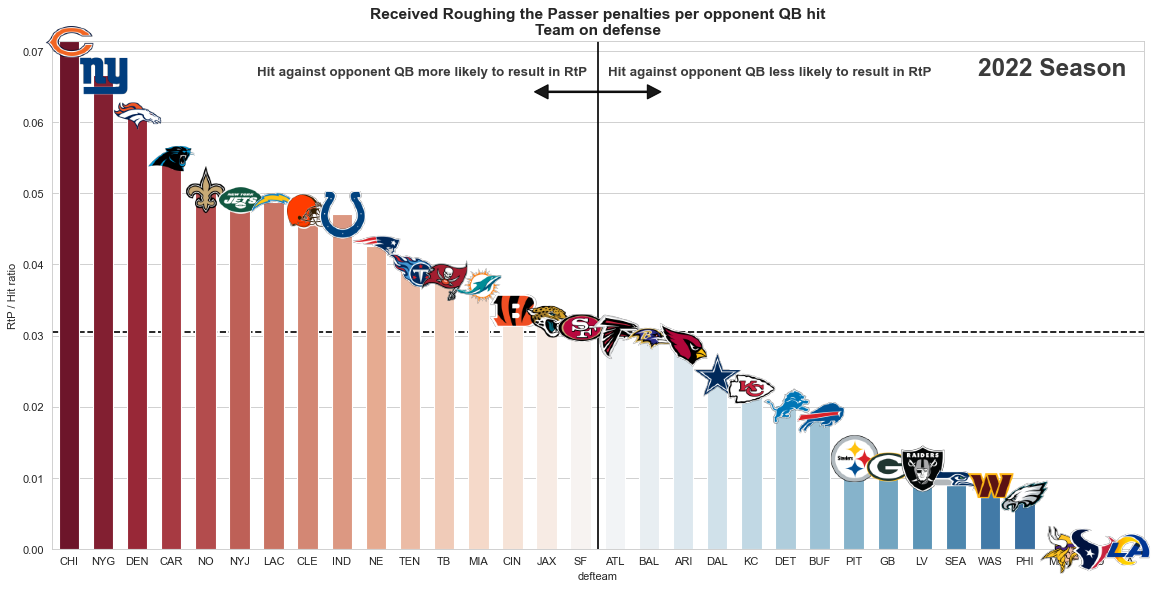

In [9]:
data=t2

fig, ax = plt.subplots(figsize=(16,8), dpi=80)

sns.barplot(ax=ax, data=data, x='defteam', y='ratio', palette='RdBu', width=0.6)
ax.set_title('Received Roughing the Passer penalties per opponent QB hit\nTeam on defense', fontsize=14, fontweight=600)
ax.set_ylabel('RtP / Hit ratio')
ax.set_yticks(np.arange(0,1,0.01))

# logos
for index, row in data.iterrows():
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{row["defteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.7)
    ab = AnnotationBbox(img, (index, row['ratio']), frameon=False)
    ax.add_artist(ab)

# median line
ax.axhline(y=data['ratio'].median(), linestyle='--', color='black', zorder=0)
# median vline
ax.axvline(x=len(data)/2-0.5, linestyle='-', color='black')

# add season text
ax.text(len(data)-1, data['ratio'].max() - (data['ratio'].max() / 15), '2022 Season', fontsize=22, fontweight=600, alpha=0.9, ha='right')

# arrows and explanation texts
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=-len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.2,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against opponent QB less likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.8,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against opponent QB more likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9, ha='right')

# set axis limits
ax.set_ylim(0,data['ratio'].max())
ax.set_xlim(0-0.5, len(data)-0.5)

plt.tight_layout()
plt.show()

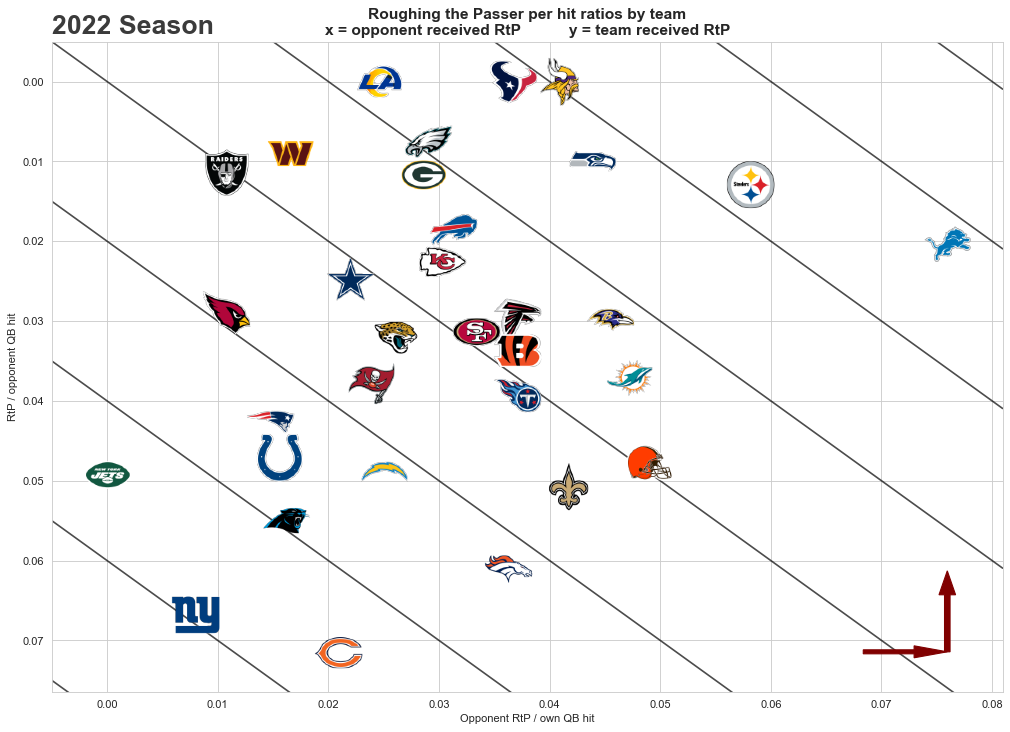

In [14]:
# scatter
x_data = t.sort_values(by='posteam').reset_index()
y_data = t2.sort_values(by='defteam').reset_index()

fig, ax = plt.subplots(figsize=(14,10), dpi=80)
sns.scatterplot(x=x_data['ratio'], y=y_data['ratio'], ax=ax, color='white')
ax.set_ylabel('RtP / opponent QB hit')
ax.set_xlabel('Opponent RtP / own QB hit')
ax.set_title('Roughing the Passer per hit ratios by team\nx = opponent received RtP           y = team received RtP', fontsize=14, fontweight=600)

for i in range(len(x_data)):
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{x_data.iloc[i]["posteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.7)
    ab = AnnotationBbox(img, (x_data.iloc[i]['ratio'], y_data.iloc[i]['ratio']), frameon=False)
    ax.add_artist(ab)

# add season text
ax.text(-0.005, data['ratio'].min() - 0.006, '2022 Season', fontsize=24, fontweight=600, alpha=0.9)

# set axis limits, invert y
ax.set_xlim(-0.005, x_data['ratio'].max()+0.005)
ax.set_ylim(-0.005, y_data['ratio'].max()+0.005)
ax.invert_yaxis()
    
# abline
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black', alpha=0.7)

for i in np.arange(-0.12, 0.12, 0.02):
    abline(1, i)
    
# add arrows
ax.arrow(x=x_data['ratio'].max()-x_data['ratio'].max()/10, y=y_data['ratio'].max(), 
         dx=x_data['ratio'].max()/10-0.003, dy=0, head_length=0.003, color='maroon', alpha=1, width=0.0005, zorder=3)
ax.arrow(x=x_data['ratio'].max(), y=y_data['ratio'].max(), 
         dx=0, dy=-y_data['ratio'].max()/10, head_length=0.003, color='maroon', alpha=1, width=0.0005, zorder=3)

plt.tight_layout()
plt.show()

In [19]:
fig = px.scatter(x=x_data['ratio'], y=y_data['ratio'], text=x_data['posteam'])
fig.show()

In [12]:
x_data

,index,posteam,rtp,hit,ratio
0,2,ARI,1,93,0.010753
1,22,ATL,3,81,0.037037
2,27,BAL,3,66,0.045455
3,17,BUF,3,96,0.031250
4,6,CAR,1,62,0.016129
5,8,CHI,2,96,0.020833
6,21,CIN,4,108,0.037037
7,29,CLE,5,102,0.049020
8,9,DAL,2,91,0.021978
9,19,DEN,5,138,0.036232


In [10]:
# calculate ratios for all teams in all seasons (2006 and later due to data from earlier seasons being weird)
t3 = df.query('season >= 2006').groupby(by=['posteam', 'season'])[['rtp', 'hit']].agg('sum').copy()
t3['ratio'] = t3['rtp'] / t3['hit']
t3 = t3.sort_values(by='ratio', ascending=False).reset_index()

In [11]:
samplemean = t3['ratio'].mean()
samplesd = t3['ratio'].std()

print('Mean: {:.5f}'.format(samplemean))
print('SD: {:.5f}'.format(samplesd))

Mean: 0.03660
SD: 0.02430


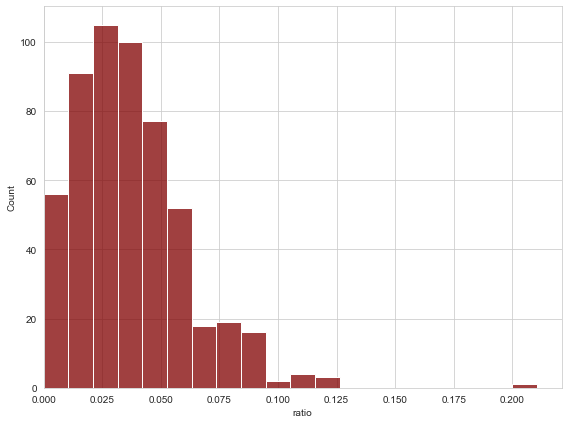

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(ax=ax, data=t3, x='ratio', bins=20, color='maroon')
ax.set_xlim(0)
plt.tight_layout()
plt.show()

In [13]:
len(t3.query('ratio <= 0.07')) / len(t3)

0.9099264705882353